# LoMST for Unsupervised Anomaly Detection

References:
I. Ahmed, A. Dagnino and Y. Ding, "Unsupervised Anomaly Detection Based on Minimum Spanning Tree Approximated Distance Measures and its Application to Hydropower Turbines," in *IEEE Transactions on Automation Science and Engineering*, vol. 16, no. 2, pp. 654-667, April 2019, doi: 10.1109/TASE.2018.2848198.

Implementing the model from the referenced paper in Python. A local minimum spanning tree is used to approximate distances of points where Euclidean distances may not be appropriate for multivariate data due to a manifold. This distance is used to isolate points of greater distances with an outlier score.

The paper can be found on the IEEE website. The data and R code for the paper can be found [here](https://zenodo.org/records/5525295). 

### Imports

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy import sparse

### Data processing
The data supplied already has duplicates, recording errors, and rows with missing data removed.

In [214]:
hydro_df = pd.read_csv('Hydropower.csv', parse_dates=['Date']).set_index('Date')  # Read csv, parse date
hydro_df.iloc[:,:10].sample(10)

,BD000fP_Air,BD000fT_Air_G,BD010fT_SOD,BD011fP_InPip,BD011fR_DistrPos,BD011fT_GBmet,BD011fT_GBmetA,BD011fT_GBoil,BD011fT_GBoilA,BD011fT_TBmet
Date,,,,,,,,,,
2016-03-21 07:30:00,962.239868,16.318302,22.264282,94.963684,62.159340,31.966125,15.647823,37.185013,20.866711,28.657593
2015-07-07 11:10:00,966.424805,29.915312,31.245132,98.042717,21.933796,42.636765,12.721453,46.017395,16.102083,38.358887
2016-01-12 13:40:00,951.867065,14.661478,16.595184,93.012604,93.136169,31.142059,16.480581,35.842377,21.180899,26.722672
2016-01-05 23:40:00,950.166504,11.648229,16.100098,97.270302,37.079155,31.215225,19.566996,36.034637,24.386408,28.730759
2015-09-17 12:40:00,957.571533,23.300526,26.246277,97.308235,36.920162,37.413589,14.113063,41.467148,18.166622,33.616394
2015-07-05 09:10:00,969.299622,27.695126,29.835205,97.858475,25.192923,41.771576,14.076450,45.056076,17.360950,37.830170
2016-03-04 00:50:00,950.676758,14.572976,20.997482,93.302917,86.928528,31.123367,16.550391,36.315018,21.742042,26.433731
2016-03-20 21:00:00,963.444885,17.162941,22.866714,95.030579,61.153591,32.467606,15.304665,37.708939,20.545998,29.112610
2015-10-17 01:55:00,965.017151,15.213244,19.741364,96.571251,50.080490,32.655075,17.441831,37.669952,22.456708,30.508133


In [215]:
def LoMST(data_df, selectedk=15):
    data = data_df.copy()
    
    # Get indices of nearest neighbors
    knn_model = NearestNeighbors(n_neighbors=selectedk+1)  # n neighbors different between R/Python
    knn_model.fit(data)
    distances, indices = knn_model.kneighbors(data)
    kn = np.array(indices)
    kn = kn[:, 1:]
    zeros = np.zeros((kn.shape[0],1), dtype=int)  # Add a column of zeros to kn
    kn = np.hstack((zeros,kn))
    
    # Calculate distance between neighbors
    dist_matrix_dict = {}
    for i in range(len(data)):
        pairwise_distances = pdist(data.iloc[kn[i,]])
        dist_matrix_dict[i] = squareform(pairwise_distances)
        
    # Calculate MST
    sumhist = np.zeros(len(data))
    compare = np.zeros(len(data))
    for i in range(len(data)):
        sparse_mat = sparse.csr_matrix(dist_matrix_dict[i])
        d = minimum_spanning_tree(sparse_mat).todense()
        d = np.where(d > 0.0, 1, 0)
        d = d + d.T  # Python MST doesn't return a symmetric matrix like R
        dist_matrix_dict[i][np.where(d == 0)] = 0
        sumhist[i] = np.sum(dist_matrix_dict[i])
    
    # Calculate Outlier score
    for i in range(len(data)):
        compare[i] = sumhist[i] - np.mean(sumhist[kn[i,]])
        
    summary = pd.DataFrame({'compare': compare})
    summary['obs'] = range(len(data))  # Add a column 'obs' with row numbers
    data['obs'] = range(len(data))
    
    final = pd.merge(summary, data, on='obs')
    final = final[['compare']]
    
    final['Outlier_Score'] = (final['compare'] - final['compare'].min()) / (final['compare'].max() - final['compare'].min())
    final.index = data.index
    
    return final #.sort_values(by='compare', ascending=False)

In [216]:
# The paper uses an average of 10, 15, and 20 neighbors
multk = pd.concat([LoMST(hydro_df, selectedk=10)['compare'],LoMST(hydro_df, selectedk=15)['compare'], LoMST(hydro_df, selectedk=20)['compare']], axis=1)

multk['avg'] = multk.mean(axis=1)

In [217]:
multk[['avg']].sort_values(by='avg', ascending=False)

,avg
Date,
2016-01-12 11:20:00,237.514440
2015-09-14 13:30:00,176.801088
2016-01-11 11:50:00,176.549147
2015-09-14 13:50:00,170.168043
2016-01-09 18:40:00,169.302347
...,...
2015-04-15 17:10:00,-12.313455
2015-04-16 04:10:00,-12.460770
2015-10-17 04:05:00,-13.561409


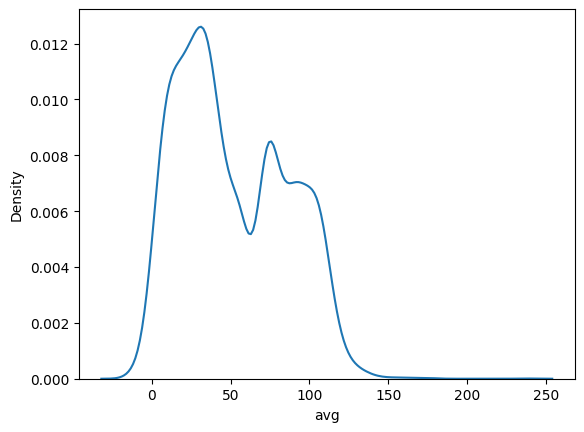

In [218]:
import seaborn as sns
sns.kdeplot(multk['avg']);

The paper selected the number of neighbors based on domain knowledge. If not known, the outlier score should stabilize for a range of values. It is believed that this means that number of neighbors works well for the manifold. So, the heuristic is to calculate the average outlier score over a range of values and to select a k in the first stable range.

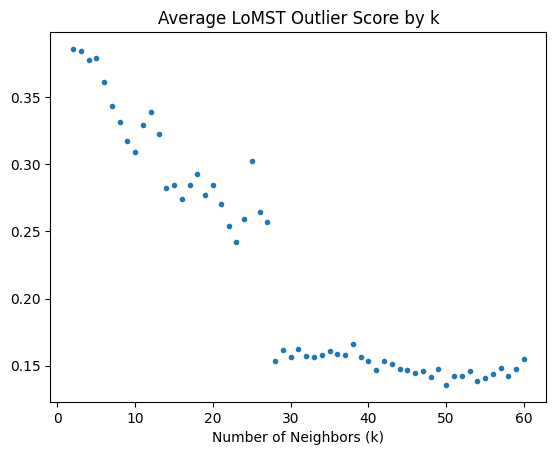

In [211]:
k_opt = np.zeros((2, 59))
for i in range(1,60):
    k_opt[0, i-1] = i+1
    res = LoMST(hydro_df, selectedk=i)
    k_opt[1, i-1] = res['Outlier_Score'].mean()

plt.title("Average LoMST Outlier Score by k")
plt.xlabel("Number of Neighbors (k)")
plt.plot(k_opt[0], k_opt[1],'.');

Based on this, I would have gone with a k in the 30s.